# Seq2seq으로 번역기 만들기



In [1]:
# !mkdir -p ~/aiffel/aiffel_projects/goingdeeper/GD8_s2s_translation

In [2]:
# !sudo apt -qq -y install fonts-nanum

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager._rebuild()

## 데이터 준비

In [19]:
import io
import os
import random
import re
import time

from tqdm import tqdm
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker

In [5]:
print(tf.__version__)

2.4.1


#### - tf.keras.utils.get_file() 함수

- url로부터 데이터를 다운 받고, 압축된 형식일 경우 해제까지 알아서 해준다.

In [6]:
path_to_zip = tf.keras.utils.get_file('spa-eng.zip',
                                     origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
                                     extract=True)

path_to_file = os.path.dirname(path_to_zip) + '/spa-eng/spa.txt'

2646016/2638744 [==============================] - 0s 0us/step


In [7]:
with open(path_to_file, 'r') as f:
    raw = f.read().splitlines()
    
print('Data Size:', len(raw))
print('Example:')
for sen in raw[:100][::20]:
    print(">>", sen)

Data Size: 118964
Example:
>> Go.	Ve.
>> Wait.	Esperen.
>> Hug me.	Abrázame.
>> No way!	¡Ni cagando!
>> Call me.	Llamame.


In [8]:
raw[:100]

['Go.\tVe.',
 'Go.\tVete.',
 'Go.\tVaya.',
 'Go.\tVáyase.',
 'Hi.\tHola.',
 'Run!\t¡Corre!',
 'Run.\tCorred.',
 'Who?\t¿Quién?',
 'Fire!\t¡Fuego!',
 'Fire!\t¡Incendio!',
 'Fire!\t¡Disparad!',
 'Help!\t¡Ayuda!',
 'Help!\t¡Socorro! ¡Auxilio!',
 'Help!\t¡Auxilio!',
 'Jump!\t¡Salta!',
 'Jump.\tSalte.',
 'Stop!\t¡Parad!',
 'Stop!\t¡Para!',
 'Stop!\t¡Pare!',
 'Wait!\t¡Espera!',
 'Wait.\tEsperen.',
 'Go on.\tContinúa.',
 'Go on.\tContinúe.',
 'Hello!\tHola.',
 'I ran.\tCorrí.',
 'I ran.\tCorría.',
 'I try.\tLo intento.',
 'I won!\t¡He ganado!',
 'Oh no!\t¡Oh, no!',
 'Relax.\tTomátelo con soda.',
 'Smile.\tSonríe.',
 'Attack!\t¡Al ataque!',
 'Attack!\t¡Atacad!',
 'Get up.\tLevanta.',
 'Go now.\tVe ahora mismo.',
 'Got it!\t¡Lo tengo!',
 'Got it?\t¿Lo pillas?',
 'Got it?\t¿Entendiste?',
 'He ran.\tÉl corrió.',
 'Hop in.\tMétete adentro.',
 'Hug me.\tAbrázame.',
 'I fell.\tMe caí.',
 'I know.\tYo lo sé.',
 'I left.\tSalí.',
 'I lied.\tMentí.',
 'I lost.\tPerdí.',
 'I quit.\tDimito.',
 'I quit.\t

#### - \t 기호를 기준으로 영어와 스페인어가 병렬 쌍을 이루고 있다.
- 따라서 \t 기호를 매개변수로 split()하면 손쉽게 소스 문장과 타겟 문장을 분리할 수 있다.
- 중간 i 같은 문자는 불필요한 노이즈로 작용할 수 있으므로 삭제한다.
- 사실 스페인에서는 역 물음표(¿)와 역 느낌표(¡)를 일반적으로 사용한다. 문장이 물음표나 느낌표로 끝난다면 해당 문장 맨 앞에 역으로 된 기호를 붙여준다.

In [22]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()
    
    sentence = re.sub(r"([?.!,])", r"\1", sentence)
    sentence = re.sub(r'[""]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    
    sentence = sentence.strip()
    
    if s_token:
        sentence = '<start> ' + sentence
    if e_token:
        sentence += ' <end>'
        
    return sentence

In [23]:
enc_corpus = []
dec_corpus = []

num_examples = 30000

for pair in raw[:num_examples]:
    eng, spa = pair.split('\t')
    
    enc_corpus.append(preprocess_sentence(eng))
    dec_corpus.append(preprocess_sentence(spa, s_token=True, e_token=True))
    
print('English:', enc_corpus[100])
print('Spanish:', dec_corpus[100])

English: go away!
Spanish: <start> salga de aqu ! <end>


In [24]:
# 토큰화
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, tokenizer

In [25]:
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

enc_train, enc_val, dec_train, dec_val = train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print('English Vocab Size:', len(enc_tokenizer.index_word))
print('Spanish Vocab Size:', len(dec_tokenizer.index_word))

English Vocab Size: 7575
Spanish Vocab Size: 12358


## 모델 설계

- Encoder는 모든 time-step의 hidden state를 출력으로 갖고, Decoder는 Encoder의 출력과 Decoder의 t-1 step의 hidden state로 Attention을 취해 t step의 hidden state를 만들어 낸다.
- Decoder에서 t step의 단어로 예측된 것을 실제 정답과 대조해 loss를 구하고, 생성된 t step의 hidden state는 t+1 step의 hidden state를 만들기 위해 다시 Decoder에 전달된다.
- t=1일 때의 hidden state는 Encoder의 final state를 사용한다.
- Attention은 Bahdanau를 사용한다.

![image](https://user-images.githubusercontent.com/80008411/137627395-957a995e-70ae-465f-8a00-99f8b329861f.png)


In [26]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [27]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [28]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [29]:
BATCH_SIZE = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 12359)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


## 모델 훈련 1) Optimizer & Loss

- Encoder-Decoder 구조의 경우 입출력이 단순하지 않아서 fit() 함수로 학습할 수 없고, 학습 과정을 직접 정의해줘야 한다.
- 구체적으로 인코더-디코더 구조는 학습 과정이 일반적이지 않아서 직접 Loss를 커스텀해야 하기 때문이다.
- SparseCategoricalCrossentropy() 함수는 모델이 출력한 확률 분포와 정수 인덱스 답안을 비교해 cross entropy 값을 구해준다.
- CategoricalCrossentropy()라면 [ 0.1, 0.2, 0.7 ] 과 One-hot 인코딩된 라벨 [0, 0, 1] 을 비교하여 점수를 채점하겠지만, SparseCategoricalCrossentropy() 함수라면 [ 0.1, 0.2, 0.7 ] 과 정수 인덱스 답안 2 를 비교하여 점수를 채점한다.
- from_logits 는 확률 분포가 Softmax를 거쳐서 들어오는지, 모델의 출력값 그대로 들어오는지를 결정한다. True는 모델의 출력값을 그대로 전달한다.
- equal() 함수에 정확히는 0 이 아닌 \<PAD> 토큰의 인덱스를 전달하는 것이 맞지만 대부분의 경우는 0으로 패딩되기 때문에 편의상 0을 전달하여 처리한다.
- 모델에게 \<PAD> 토큰이 패딩을 위한 토큰이라고 명시하지 않으면 모델은 데이터의 굉장히 많은 부분이 \<PAD> 로 이뤄져 있다고 생각하기 때문에 이 과정은 중요하다.

In [30]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

## 모델 훈련 2) train_step 구현

- train_step()은 학습에 필요한 것을 모두 가져가 Loss를 계산한 후 반환하는 함수이다. 학습 과정은 다음과 같다.
    - 1) Encoder에 소스 문장을 전달해 context vector인 enc_out을 생성
    - 2) t=0일 때, Decoder의 hidden state는 Encoder의 final state로 정의 # h_dec = enc_out[:, -1]
    - 3) Decoder에 입력으로 전달할 \<start> 토큰 문장 생성
    - 4) \<start> 문장과 enc_out, hidden state를 기반으로 다음 단어(t=1) 예측 # pred
    - 5) 예측된 단어와 정답 간의 loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용(예측 단어 X)
    - 6) 반복
- @tf.function 데코레이터는 훈련 외적인 텐서플로우 연산을 GPU에서 동작하게 해서 훈련을 가속할 수 있도록 도와준다.
    - 첫 번째 epoch이 다른 epoch보다 약간 시간이 더 걸리는 것은 데코레이터가 붙은 함수를 GPU에 등록하는 과정이 포함되기 때문
    - 실제로 @tf.function을 제거할 경우, epoch당 1.5 ~ 2배 이상 더 많은 시간이 소요된다.
- tf.GradientTape()는 학습하며 발생한 모든 연산을 기록하는 테이프
    - 모델이 각 스텝의 최종 단계에서 미분값을 구하는 데에 사용된다.

In [33]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']]*bsz, 1)
        
        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)
            
            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
            
        batch_loss = (loss/int(tgt.shape[1]))
        
        variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        
        return batch_loss

## 모델 훈련 3) 시작

In [34]:
EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 375/375 [01:42<00:00,  3.65it/s, Loss 0.1486]


## 실습

- eval_step() 함수 정의
    - step 1에서 분리한 validation set을 사용하는 함수
    - train_step()을 마친 후 이어서 eval_step()을 진행하도록 수정하기
    - evaluation 중에는 train이 되면 안 된다.

In [35]:
# gradient, optimizer 부분만 없고 train_step()과 동일
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)
    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']]*bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss/int(tgt.shape[1]))

    return batch_loss

In [37]:
EPOCHS = 10

for epoch in range(EPOCHS):
    # train
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm
    
    # evaluation
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)
    
    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                   dec_val[idx:idx+BATCH_SIZE],
                                   encoder,
    https://8888-wwnzlh3gj0udj7zuvm97u1n28.e.aiffel-3.ainetwork.ai/notebooks/aiffel/aiffel_projects/goingdeeper/GD8_s2s_translation/GD8_seq2seq_translator.ipynb#                               decoder,
                                   dec_tokenizer)
        test_loss += test_batch_loss
        
        t.set_description_str('Test Epoch %2d' %(epoch+1))
        t.set_postfix_str('Test Loss %.4f' %(test_loss.numpy() / (test_batch+1)))

Test Epoch 10: 100%|██████████| 94/94 [00:08<00:00, 10.46it/s, Test Loss 1.0572]


Input: can i have some coffee?
Predicted translation: me concedes algo de comer. <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


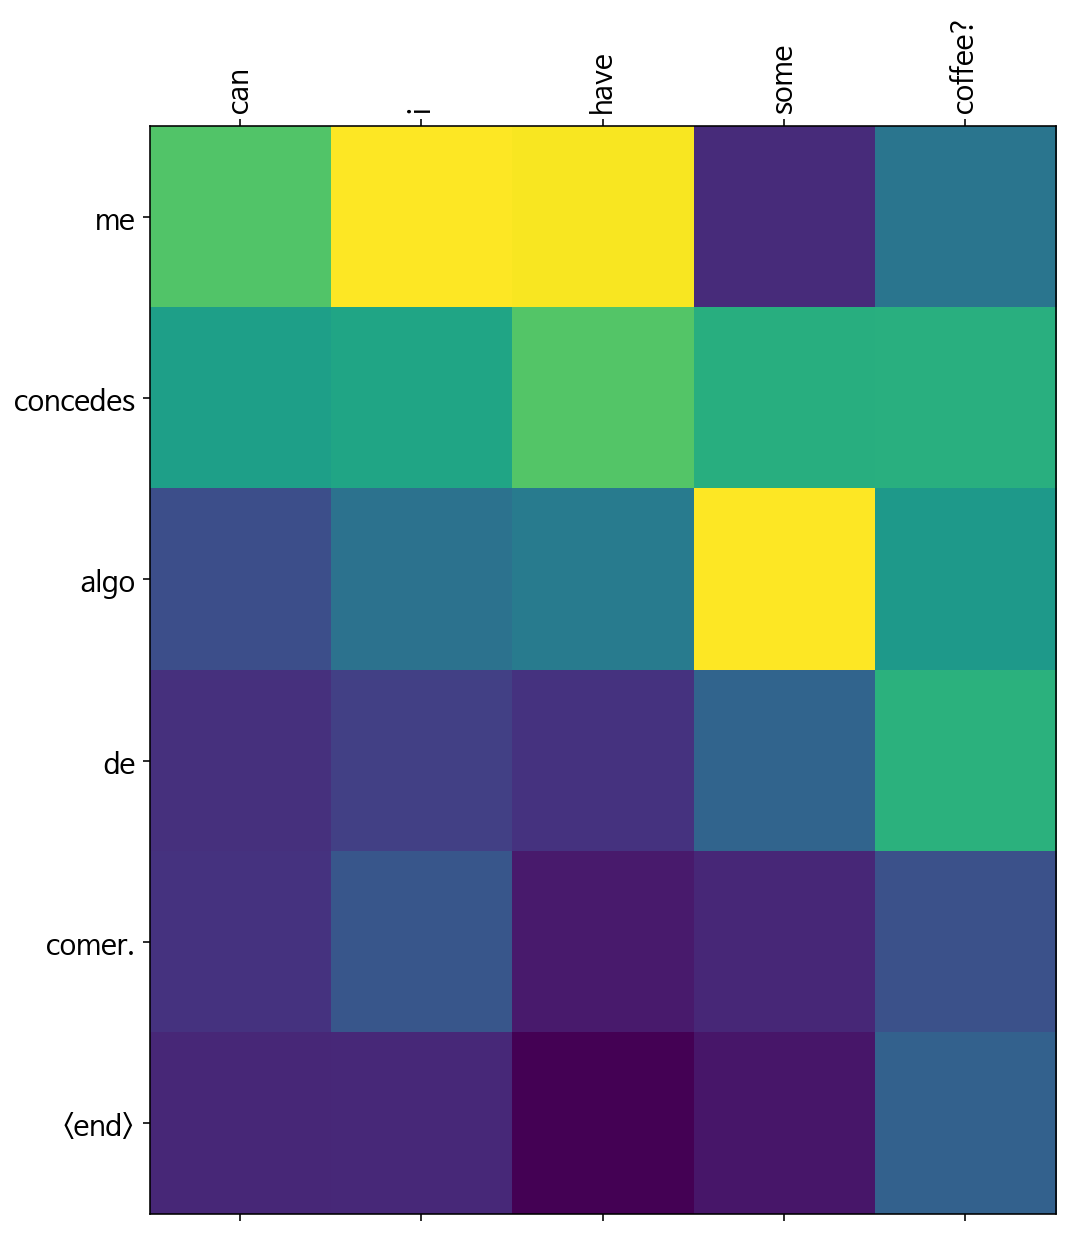

In [38]:
# 번역 성능 평가하는 함수
# 보너스로 attention map 시각화
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=enc_train.shape[-1],
                                                          padding='post')
    
    result = ''
    
    enc_out = encoder(inputs)
    
    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)
    
    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                            dec_hidden,
                                                            enc_out)
        attention_weights = tf.reshape(attention_weights, (-1))
        attention[t] = attention_weights.numpy()
        
        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()
        
        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("Can I have some coffee?", encoder, decoder)